# **Complete Guide to Gaussian Naive Bayes Classification in PySpark ML:  Optimization insights**

### **`Dr Amin Karami (PhD, FHEA, EE), UEL UK - Docklands Campus`**

`E: amin.karami@ymail.com`

`W: https://www.youtube.com/@AminKarami`

`W: https://www.aminkarami.com`

---

**Learning Outcomes**:

- Gain a comprehensive understanding of the Gaussian Naive Bayes algorithm and its underlying assumptions in the context of classification tasks

- Learn how to preprocess and prepare your dataset for Gaussian Naive Bayes classification using PySpark ML's powerful data transformation and feature engineering capabilities

- Explore various evaluation metrics and techniques to assess the performance of your Gaussian Naive Bayes classifier

- Dive into advanced techniques for tuning and optimizing your Gaussian Naive Bayes model, including greedy search and random search methods


In [ ]:
# !pip3 install pyspark

# **Step 1:** Import the required libraries and initialize SparkSession.

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, MinMaxScaler, RobustScaler
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize SparkSession
spark = SparkSession.builder \
                    .appName("NaiveBayesClassifierExample") \
                    .master("local[*]") \
                    .config("spark.executor.memory", "4g") \
                    .config("spark.driver.memory", "2g") \
                    .config("spark.executor.cores", "2") \
                    .config("spark.sql.inMemoryColumnarStorage.compressed", "true") \
                    .getOrCreate()

spark

# **Step 2:** Load and preprocess the data.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# **KDDCup Data**:

The dataset contains network intrusion detection data, which is used to develop and test algorithms for detecting unauthorized access to computer networks. The KDD Cup 1999 Data has been widely used in the research community for developing and testing intrusion detection systems.

URL: https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

Data Description: https://kdd.ics.uci.edu/databases/kddcup99/task.html

Features: https://kdd.ics.uci.edu/databases/kddcup99/kddcup.names

Labels: https://kdd.ics.uci.edu/databases/kddcup99/training_attack_types


# Data Collection:

[The full data set](https://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz) (18M; 743M Uncompressed)

[A 10% subset](https://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz) (2.1M; 75M Uncompressed)


In [3]:
# Load the compressed file as a text file
df = spark.read.csv("kddcup.data_10_percent.gz", header = False)

# Display the DataFrame
df.show(5)

# more info
print(df.count())
print(df.rdd.getNumPartitions())

+---+---+----+---+---+----+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-------+
|_c0|_c1| _c2|_c3|_c4| _c5|_c6|_c7|_c8|_c9|_c10|_c11|_c12|_c13|_c14|_c15|_c16|_c17|_c18|_c19|_c20|_c21|_c22|_c23|_c24|_c25|_c26|_c27|_c28|_c29|_c30|_c31|_c32|_c33|_c34|_c35|_c36|_c37|_c38|_c39|_c40|   _c41|
+---+---+----+---+---+----+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-------+
|  0|tcp|http| SF|181|5450|  0|  0|  0|  0|   0|   1|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   8|   8|0.00|0.00|0.00|0.00|1.00|0.00|0.00|   9|   9|1.00|0.00|0.11|0.00|0.00|0.00|0.00|0.00|normal.|
|  0|tcp|http| SF|239| 486|  0|  0|  0|  0|   0|   1|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   8|   8|0.00|0.00|0.00|0.00|1.00|0.00|0.00|  19|  19|1.00|0.00|0.05

# Add header

In [4]:
df = df.withColumnRenamed("_c0","duration") \
      .withColumnRenamed("_c1","protocol_type")\
      .withColumnRenamed("_c2","service")\
      .withColumnRenamed("_c3","flag")\
      .withColumnRenamed("_c4","src_bytes")\
      .withColumnRenamed("_c5","dst_bytes")\
      .withColumnRenamed("_c6","land")\
      .withColumnRenamed("_c7","wrong_fragment")\
      .withColumnRenamed("_c8","urgent")\
      .withColumnRenamed("_c9","host")\
      .withColumnRenamed("_c10","num_failed_logins")\
      .withColumnRenamed("_c11","logged_in")\
      .withColumnRenamed("_c12","num_compromised")\
      .withColumnRenamed("_c13","root_shell")\
      .withColumnRenamed("_c14","su_attempted")\
      .withColumnRenamed("_c15","num_root")\
      .withColumnRenamed("_c16","num_file_creations")\
      .withColumnRenamed("_c17","num_shells")\
      .withColumnRenamed("_c18","num_access_files")\
      .withColumnRenamed("_c19","num_outbound_cmds")\
      .withColumnRenamed("_c20","is_host_login")\
      .withColumnRenamed("_c21","is_guest_login")\
      .withColumnRenamed("_c22","count")\
      .withColumnRenamed("_c23","srv_count")\
      .withColumnRenamed("_c24","serror_rate")\
      .withColumnRenamed("_c25","srv_serror_rate")\
      .withColumnRenamed("_c26","rerror_rate")\
      .withColumnRenamed("_c27","srv_rerror_rate")\
      .withColumnRenamed("_c28","same_srv_rate")\
      .withColumnRenamed("_c29","diff_srv_rate")\
      .withColumnRenamed("_c30","srv_diff_host_rate")\
      .withColumnRenamed("_c31","dst_host_count")\
      .withColumnRenamed("_c32","dst_host_srv_count")\
      .withColumnRenamed("_c33","dst_host_same_srv_rate")\
      .withColumnRenamed("_c34","dst_host_diff_srv_rate")\
      .withColumnRenamed("_c35","dst_host_same_src_port_rate")\
      .withColumnRenamed("_c36","dst_host_srv_diff_host_rate")\
      .withColumnRenamed("_c37","dst_host_serror_rate")\
      .withColumnRenamed("_c38","dst_host_srv_serror_rate")\
      .withColumnRenamed("_c39","dst_host_rerror_rate")\
      .withColumnRenamed("_c40","dst_host_srv_rerror_rate")\
      .withColumnRenamed("_c41","connection_status")

df.show(5)

+--------+-------------+-------+----+---------+---------+----+--------------+------+----+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-----------------+
|duration|protocol_type|service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|host|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_diff_host_

# Check the Multi-class labels (Multi-label classification)

In [23]:
df.select("connection_status").distinct().show(30)


+-----+
|label|
+-----+
|  0.0|
|  1.0|
|  2.0|
|  3.0|
|  4.0|
|  5.0|
|  6.0|
|  7.0|
|  8.0|
|  9.0|
| 10.0|
| 11.0|
| 12.0|
| 13.0|
| 14.0|
| 15.0|
| 16.0|
| 17.0|
| 18.0|
| 19.0|
| 20.0|
| 21.0|
| 22.0|
+-----+



# Count the labels

In [9]:
df.groupBy("connection_status").count().orderBy('count', ascending = False).show()

+-----------------+------+
|connection_status| count|
+-----------------+------+
|           smurf.|280790|
|         neptune.|107201|
|          normal.| 97278|
|            back.|  2203|
|           satan.|  1589|
|         ipsweep.|  1247|
|       portsweep.|  1040|
|     warezclient.|  1020|
|        teardrop.|   979|
|             pod.|   264|
|            nmap.|   231|
|    guess_passwd.|    53|
| buffer_overflow.|    30|
|            land.|    21|
|     warezmaster.|    20|
|            imap.|    12|
|         rootkit.|    10|
|      loadmodule.|     9|
|       ftp_write.|     8|
|        multihop.|     7|
+-----------------+------+
only showing top 20 rows



# StringIndexer for other features

In [10]:
# to map labels to indicies

indexer = StringIndexer(inputCol = 'connection_status', outputCol = 'label')
df = indexer.fit(df).transform(df)

In [15]:
df.groupBy("label").count().orderBy('count', ascending = False).show()

+-----+------+
|label| count|
+-----+------+
|  0.0|280790|
|  1.0|107201|
|  2.0| 97278|
|  3.0|  2203|
|  4.0|  1589|
|  5.0|  1247|
|  6.0|  1040|
|  7.0|  1020|
|  8.0|   979|
|  9.0|   264|
| 10.0|   231|
| 11.0|    53|
| 12.0|    30|
| 13.0|    21|
| 14.0|    20|
| 15.0|    12|
| 16.0|    10|
| 17.0|     9|
| 18.0|     8|
| 19.0|     7|
+-----+------+
only showing top 20 rows



# VectorAssembler
Prepare the features column (Use VectorAssembler to combine features into a single vector column)

In [16]:
# drop unnessary features
exclude_cols = ["duration", "protocol_type", "service", "flag", "connection_status"]
input_cols = [col for col in df.columns if col not in exclude_cols]
df = df[input_cols]

df.show(2)

+---------+---------+----+--------------+------+----+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-----+
|src_bytes|dst_bytes|land|wrong_fragment|urgent|host|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_diff_host_rate|dst_host_count|dst_host_srv_count|dst_host_same_srv_rate|dst_host_diff_srv_rate

In [ ]:
# drop unnessary features
exclude_cols = ["duration", "protocol_type", "service", "flag", "connection_status"]
input_cols = [col for col in df.columns if col not in exclude_cols]
df = df[input_cols]

df.show(2)

+---------+---------+----+--------------+------+----+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-----+
|src_bytes|dst_bytes|land|wrong_fragment|urgent|host|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_diff_host_rate|dst_host_count|dst_host_srv_count|dst_host_same_srv_rate|dst_host_diff_srv_rate

# Normalization and Standardization
To ensure that the features are on a similar scale, which can be beneficial for various machine learning algorithms. By standardizing the features, you can mitigate the impact of variables with larger scales dominating the learning process and potentially improve the model's performance.

`Normalization`: Normalization refers to scaling the values of a feature to a specific range, typically between 0 and 1. This ensures that all values are proportionally adjusted within the specified range. **MinMaxScaler** is an example of a normalization technique, as it scales the features to a predefined range.

`Standardization`: Standardization involves transforming the values of a feature to have zero mean and unit variance. This technique ensures that the feature follows a standard normal distribution. **StandardScaler** is an example of a standardization technique, as it removes the mean and scales the features to have unit variance.

# Split Data: Training and Testing

# **Step 3:** Apply Naive Bayes model.


**Smoothing (laplace)**: The smoothing parameter is used to handle scenarios where a particular feature value is not present in the training data for a specific class. By default, the NaiveBayes model in PySpark applies `Laplace smoothing (add-one smoothing)` with a smoothing parameter of 1.0. However, you can adjust this parameter to control the level of smoothing. Higher smoothing values can help avoid zero probabilities for unseen features, but they can also introduce bias.

# **Step 4:** Evaluate the model.

# Confusion Matrix

Please note that in multi-label classification, the TP, TN, FP, and FN metrics are generally not used since they are more relevant to binary classification. Instead, metrics such as precision, recall, F1-score, and Hamming loss provide a better understanding of the model's performance in the context of multi-label classification tasks.

## Additional Performance metrics

**Hamming Loss:**
- HammingLoss is a metric used for multi-label classification problems.
- It measures the fraction of labels that are incorrectly predicted.
- The ideal value of Hamming Loss is 0, indicating perfect prediction, while a value of 1 indicates all labels are predicted incorrectly.
- Lower values of Hamming Loss indicate better model performance.

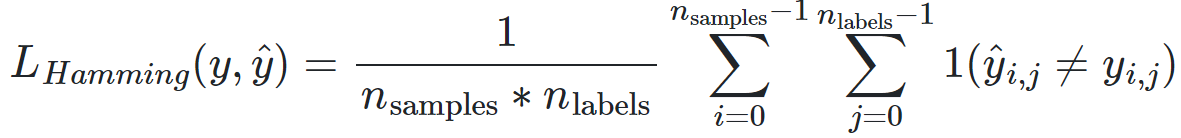


**Log Loss:**

- LogLoss, also known as log loss or cross-entropy loss, is a metric commonly used for binary or multi-class classification problems.
- It measures the performance of a classifier that outputs probabilities by quantifying the difference between predicted probabilities and the true labels.
- Log Loss penalizes confident and incorrect predictions more severely.
- The ideal value of Log Loss is 0, indicating perfect prediction, while higher values indicate worse performance.


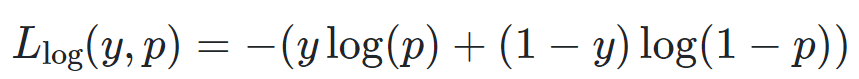

# **Step 5:** Optimization (Grid Search and Random Search)

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Grid Search results

# Random Search results